<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import os
import sys

path = os.getcwd().split("/")[:-1]
path = "/".join(path)
sys.path.append(path)

from IPython.display import Image
import numpy as np
from models.altLogNormPSM import LogNormPSM
from models.altNormPSM import NormPSM
from models.GAModel import GAModel
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import math

## Initial Values of System

**M**: *int* = Num of sequences;

**n_max**: *int* = Number of pairs in native arrangment, where n in {0, ..., M};

**n_bins**: *int* = Number of intervals in I;

**i_nat**: *float* = Value of i for native arrangment;

**i_0**: *float* = I mean for arrangments with n = 0;

**sigma2_0**: *float* = Variance of I for arrangments with n = 0;

**n_step**: *int* = Max n transition in genetic algorithm.

In [5]:
M = 10             
n_max = M + 1 
n_bins = M + 1 
i_nat = 7
i_0 = 1 
sigma2_0 = 0.02
n_step = 1
minimize = False

## Protein System Model Instance

### log-norm protein system model

In [6]:
ln_psm = LogNormPSM(M, i_0, i_nat, sigma2_0)

### norm protein system model

In [7]:
n_psm = NormPSM(M, i_0, i_nat, sigma2_0)

In [19]:
# get data
l_data, l_bins_center = ln_psm.create_data()
n_data, n_bins_center = n_psm.create_data()

# data fitted in norm and probs without poisson weight
l_pdfs, l_probs = ln_psm.get_prob_bins()
n_pdfs, n_probs = n_psm.get_prob_bins()

# probs with Poisson weight
lw_probs = ln_psm.get_probs()
nw_probs = n_psm.get_probs()

print(np.sum(nw_probs), np.sum(lw_probs))

# reassessed probs with Poisson weight
rlw_probs = ln_psm.reassessment_probs(lw_probs)
rnw_probs = n_psm.reassessment_probs(nw_probs)

0.9999999899522337 0.9999999899522337


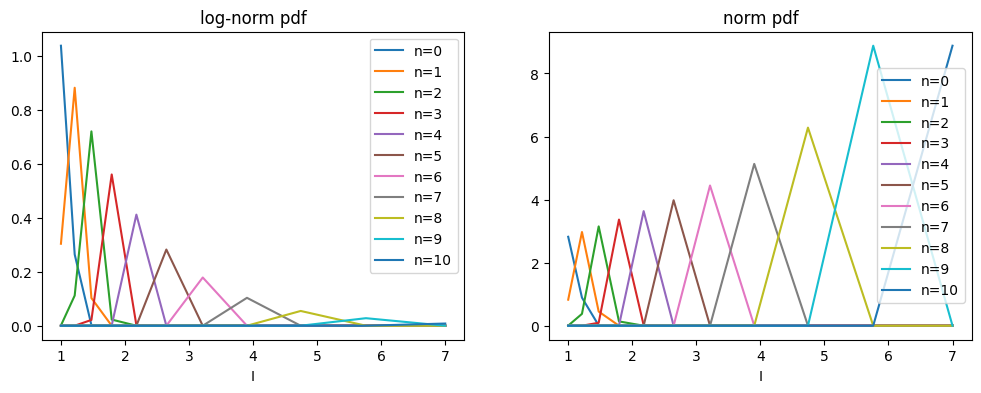

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
cmap = "plasma"

for n, curve in enumerate(l_pdfs):
    axs[0].plot(n_bins_center, curve, label=f"n={n}")
axs[0].set_title("log-norm pdf")
axs[0].set_xlabel("I")
axs[0].legend()

for n, curve in enumerate(n_pdfs):
    axs[1].plot(n_bins_center, curve, label=f"n={n}")
axs[1].set_title("norm pdf")
axs[1].set_xlabel("I")

axs[1].legend()
plt.show()


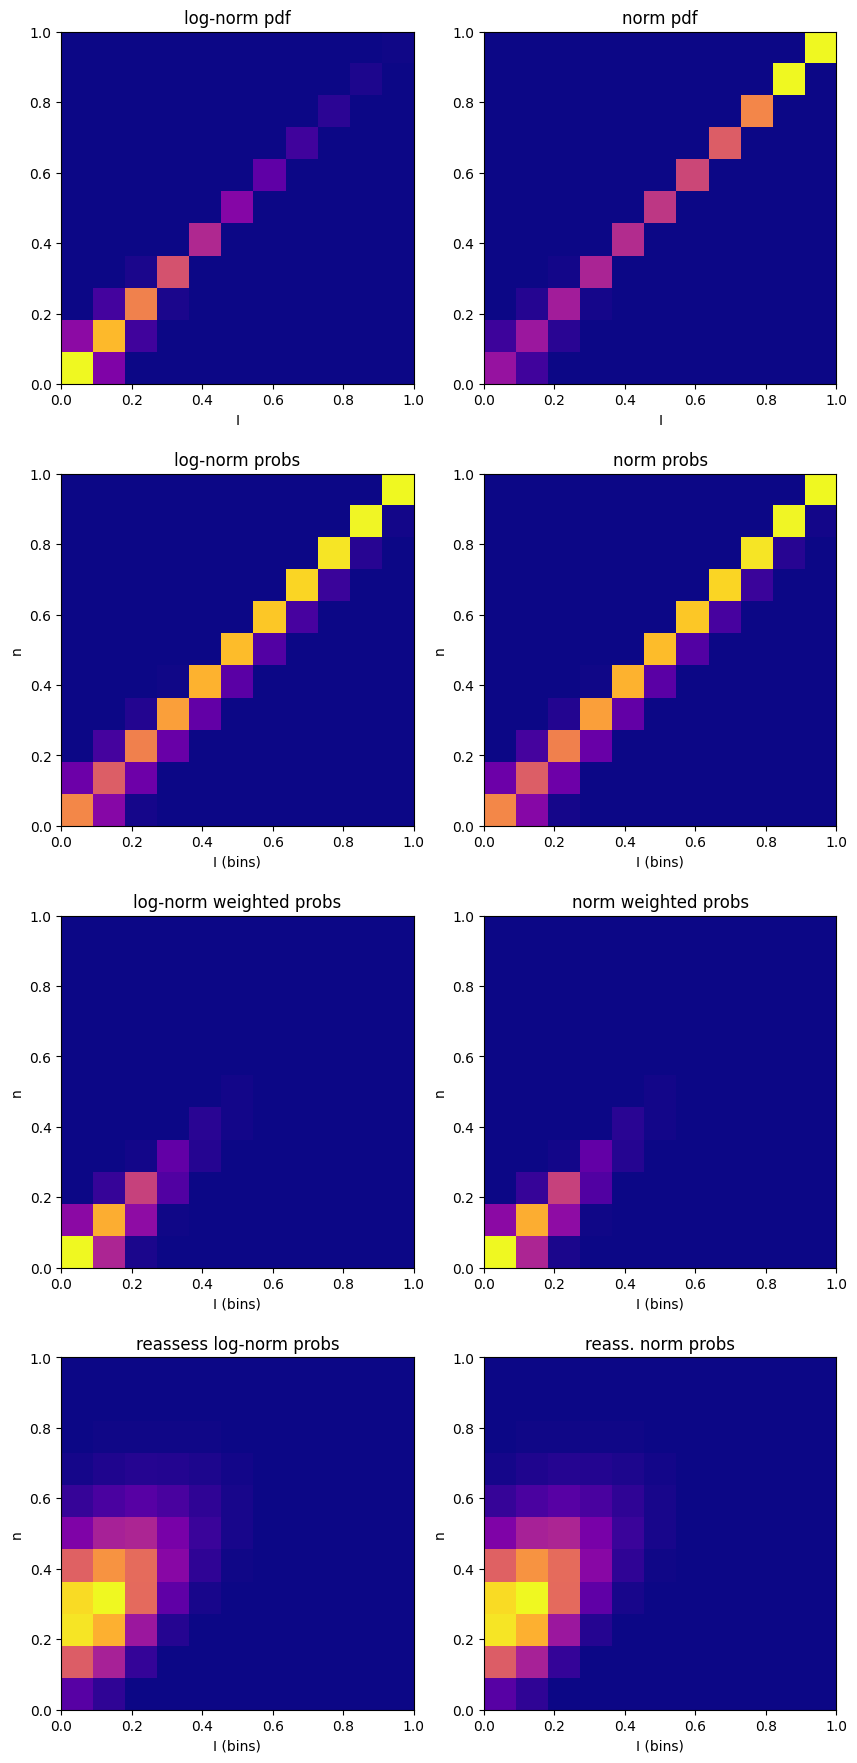

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(10, 22))
cmap = "plasma"

c = axs[0, 0].imshow(l_pdfs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[0, 0].set_title("log-norm pdf")
axs[0, 0].set_xlabel("I")

nc = axs[0, 1].imshow(n_pdfs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[0, 1].set_title("norm pdf")
axs[0, 1].set_xlabel("I")

lc = axs[1, 0].imshow(l_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[1, 0].set_title("log-norm probs")
axs[1, 0].set_xlabel("I (bins)")
axs[1, 0].set_ylabel("n")

nc = axs[1, 1].imshow(n_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[1, 1].set_title("norm probs")
axs[1, 1].set_xlabel("I (bins)")
axs[1, 1].set_ylabel("n")

lc = axs[2, 0].imshow(lw_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[2, 0].set_title("log-norm weighted probs")
axs[2, 0].set_xlabel("I (bins)")
axs[2, 0].set_ylabel("n")

nc = axs[2, 1].imshow(nw_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[2, 1].set_title("norm weighted probs")
axs[2, 1].set_xlabel("I (bins)")
axs[2, 1].set_ylabel("n")

lc = axs[3, 0].imshow(rlw_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[3, 0].set_title("reassess log-norm probs")
axs[3, 0].set_xlabel("I (bins)")
axs[3, 0].set_ylabel("n")

nc = axs[3, 1].imshow(rnw_probs[::-1], extent=[0, 1, 0, 1], cmap=cmap,  interpolation='nearest')
axs[3, 1].set_title("reass. norm probs")
axs[3, 1].set_xlabel("I (bins)")
axs[3, 1].set_ylabel("n")

plt.show()

## GA Model Instance

In [12]:
ga_model = GAModel()

## Get transitions matrix

In [13]:
l_idx, l_transitions = ga_model.get_transitions_matrix(lw_probs, n_step=n_step)
n_idx, n_transitions = ga_model.get_transitions_matrix(nw_probs, n_step=n_step)


## Get best path in GA for a system

#### Method returns probs for each step and path.

In [15]:
l_step_probs, l_path = ga_model.get_best_path(lw_probs, minimize=False)
n_step_probs, n_path = ga_model.get_best_path(nw_probs, minimize=False)

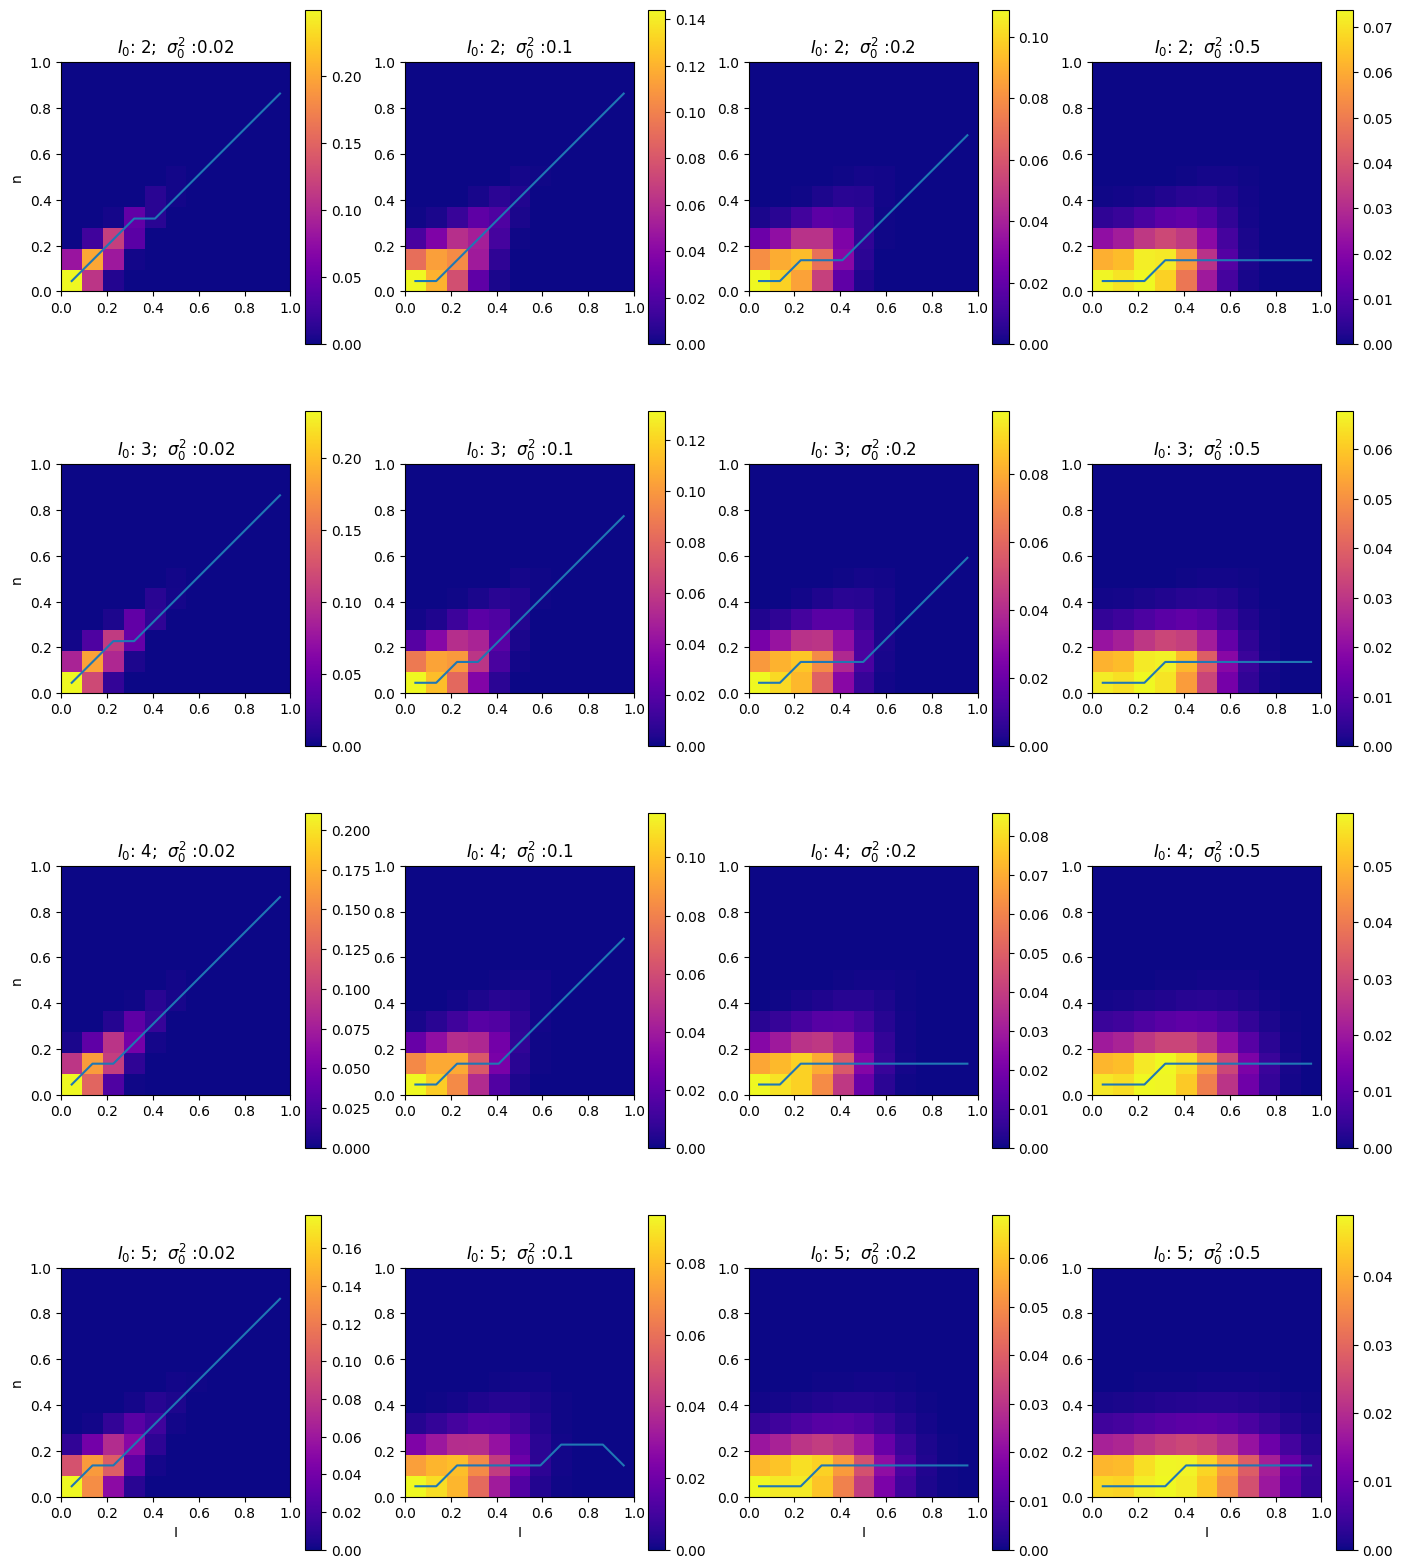

In [16]:
fig, axs = plt.subplots(4, 4, figsize=(17, 20))
cmap = "plasma"

i_0s = [2, 3, 4, 5] 
sigmas2_0 = [0.02, 0.1, 0.2, 0.5]

for idx1, i0 in enumerate(i_0s):
    for idx2, s0 in enumerate(sigmas2_0):

        sys_model = LogNormPSM(M, i0, i_nat, s0)
        prob_arr = sys_model.get_probs()
        ga_model = GAModel()
        path = ga_model.get_best_path(prob_arr, minimize=minimize)[0]
        z_prob = np.fliplr(prob_arr[::-1]) if minimize else prob_arr[::-1]
        c = axs[idx1, idx2].imshow(z_prob, extent=[0, 1, 0, 1], 
                                   cmap=cmap,  interpolation='nearest')
        x = [(x[1] / n_bins) + 0.5 * 1 / n_bins for x in path]
        y = [(x[0] / (n_max)) + 0.5 * 1 / (n_max) for x in path]
        ax=axs[idx1, idx2]
        fig.colorbar(c, ax=ax)
        axs[idx1, idx2].plot(x, y)
        axs[idx1, idx2].set_title("".join([r'$I _{0}$', f": {i0};  ", 
                                           r'$\sigma _{0} ^{2}$', f" :{s0}"]))
        
        if idx2 == 0:
            axs[idx1, idx2].set_ylabel("n")
        if idx1 == 3:
            axs[idx1, idx2].set_xlabel("I")
            

plt.show()

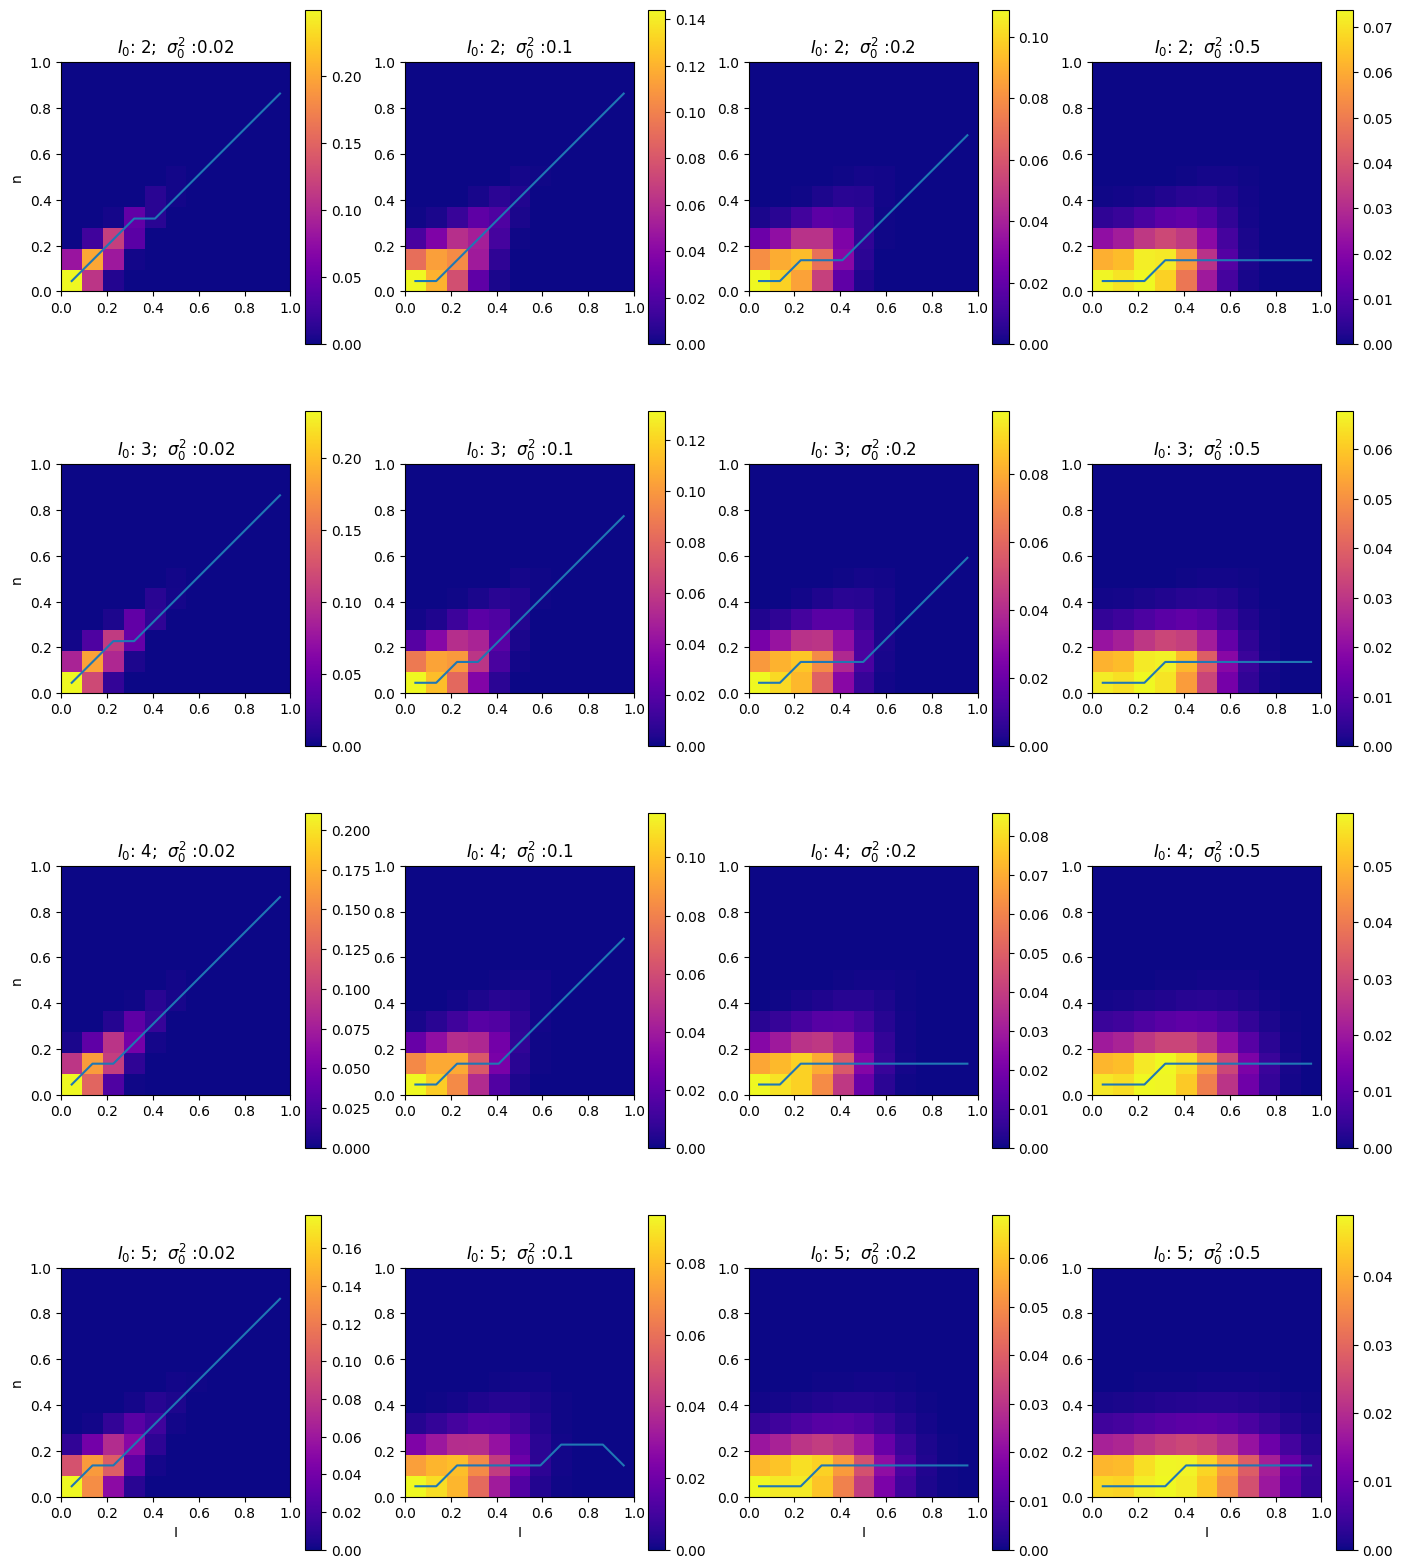

In [17]:
fig, axs = plt.subplots(4, 4, figsize=(17, 20))
cmap = "plasma"

i_0s = [2, 3, 4, 5] 
sigmas2_0 = [0.02, 0.1, 0.2, 0.5]

for idx1, i0 in enumerate(i_0s):
    for idx2, s0 in enumerate(sigmas2_0):

        sys_model = NormPSM(M, i0, i_nat, s0)
        prob_arr = sys_model.get_probs()
        ga_model = GAModel()
        path = ga_model.get_best_path(prob_arr, minimize=minimize)[0]
        z_prob = np.fliplr(prob_arr[::-1]) if minimize else prob_arr[::-1]
        c = axs[idx1, idx2].imshow(z_prob, extent=[0, 1, 0, 1], 
                                   cmap=cmap,  interpolation='nearest')
        x = [(x[1] / n_bins) + 0.5 * 1 / n_bins for x in path]
        y = [(x[0] / (n_max)) + 0.5 * 1 / (n_max) for x in path]
        ax=axs[idx1, idx2]
        fig.colorbar(c, ax=ax)
        axs[idx1, idx2].plot(x, y)
        axs[idx1, idx2].set_title("".join([r'$I _{0}$', f": {i0};  ", 
                                           r'$\sigma _{0} ^{2}$', f" :{s0}"]))
        
        if idx2 == 0:
            axs[idx1, idx2].set_ylabel("n")
        if idx1 == 3:
            axs[idx1, idx2].set_xlabel("I")
            

plt.show()